In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

## Install Segment Anything Model (SAM) and other dependencies

In [3]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [4]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 25.9 MB/s eta 0:00:00


### Download SAM weights

In [5]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [6]:
import os
HOME="/content/{HOME}"
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/{HOME}/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [7]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [8]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## Segmentation with bounding box

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [9]:
mask_predictor = SamPredictor(sam)

### Nifti

In [10]:
import nibabel as nib

In [11]:
nifti = nib.load('/content/drive/MyDrive/Udemy_AI_in_Medical_Image_Analysis_MATERIALS/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/imagesTr/liver_0.nii.gz')

In [12]:
image_array = nifti.get_fdata()

In [13]:
image_array.shape

(180, 180, 125)

In [14]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded


In [15]:
import io
from PIL import Image
import base64
import numpy as np
from jupyter_bbox_widget import BBoxWidget

def convert_to_uint8(image_array):
    if image_array.dtype == np.uint16:
        image_array = ((image_array / image_array.max()) * 255).astype(np.uint8)
    return image_array

def encode_image_from_array(image_array):
    image_array = convert_to_uint8(image_array)

    image_pil = Image.fromarray(image_array)
    buffer = io.BytesIO()
    image_pil.save(buffer, format="PNG")
    encoded = base64.b64encode(buffer.getvalue()).decode('utf-8')
    return "data:image/png;base64," + encoded

In [16]:
import cv2
from IPython.display import display, clear_output
images=[]
for i in range(image_array.shape[-1]):
  image_rescaled = ((image_array[:, :, i] - np.min(image_array[:, :, i])) /
                      (np.max(image_array[:, :, i]) - np.min(image_array[:, :, i])) * 255).astype(np.uint8)
  image_rgb = cv2.cvtColor(image_rescaled, cv2.COLOR_GRAY2RGB)
  encoded_image = encode_image_from_array(image_rgb)
  images.append(encoded_image)

In [17]:
len(images)

125

You don't have to segment all 125 images. Just do a few and go to next cells. Please draw more than 1 bounding box in some images.

In [18]:
boxes = []
widget = BBoxWidget()
current_image = 0  # Track the current image index

def load_image():
    global current_image
    widget.bboxes = []
    clear_output(wait=True)
    # Check if there are images left to annotate
    if current_image < len(images):
        widget.image = images[current_image]
        print(f"Annotating image {current_image + 1}/{len(images)}")
        display(widget)
    else:
        print("All images have been processed.")

@widget.on_submit
def save():
    global current_image
    # Append the current bounding boxes to `boxes`
    boxes.append(widget.bboxes)
    print(f"Saved bounding boxes for image {current_image}: {widget.bboxes}")

    # Move to the next image
    current_image += 1
    load_image()

@widget.on_skip
def skip():
    global current_image
    print(f"Skipped image {current_image}")

    # Move to the next image without saving
    current_image += 1
    load_image()

# Start the annotation workflow
load_image()


Annotating image 6/125


BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [19]:
boxes

[[{'x': 76, 'y': 16, 'width': 25, 'height': 25, 'label': ''},
  {'x': 67, 'y': 142, 'width': 25, 'height': 25, 'label': ''}],
 [{'x': 76, 'y': 15, 'width': 24, 'height': 27, 'label': ''},
  {'x': 66, 'y': 141, 'width': 26, 'height': 27, 'label': ''}],
 [{'x': 63, 'y': 51, 'width': 28, 'height': 27, 'label': ''},
  {'x': 58, 'y': 102, 'width': 29, 'height': 27, 'label': ''}],
 [{'x': 73, 'y': 16, 'width': 27, 'height': 26, 'label': ''}],
 [{'x': 73, 'y': 15, 'width': 27, 'height': 28, 'label': ''}]]

In [20]:
not boxes[1]

False

In [21]:
import numpy as np

box_arrays = []

# Iterate over each list in boxes
for box_list in boxes:
    if not box_list:  # Check if box_list is empty
        # Append an array of zeros for empty box_list
        box_arrays.append(np.array([[0, 0, 0, 0]]))  # Using 2D array for consistency
    else:
        b = []  # Initialize b for non-empty box_list
        for box in box_list:
            box_coords = [
                box['x'],
                box['y'],
                box['x'] + box['width'],
                box['y'] + box['height']
            ]
            b.append(np.array(box_coords))  # Append box coordinates to b

        box_arrays.append(np.array(b))  # Append the list of boxes to box_arrays

# Print all bounding boxes for the first image
print("All bounding boxes of image 1:", box_arrays)


All bounding boxes of image 1: [array([[ 76,  16, 101,  41],
       [ 67, 142,  92, 167]]), array([[ 76,  15, 100,  42],
       [ 66, 141,  92, 168]]), array([[ 63,  51,  91,  78],
       [ 58, 102,  87, 129]]), array([[ 73,  16, 100,  42]]), array([[ 73,  15, 100,  43]])]


['',
 '',
 '',
 '',
 '']
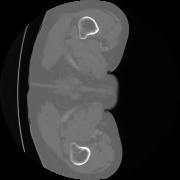
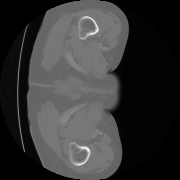
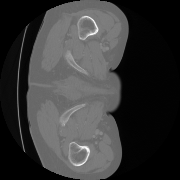
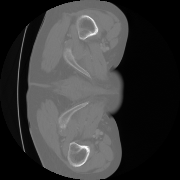
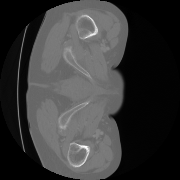

In [22]:
images=images[:len(box_arrays)]
images

In [23]:
image_array[:,:,1]

array([[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       ...,
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.]])

In [24]:
import cv2
import numpy as np

new_images = []
for i in range(len(images)):
    if image_array.ndim != 3:
        raise ValueError("image_array must be a 3D array with shape (height, width, number_of_images)")

    image_gray = image_array[:, :, i]
    image_rgb = cv2.cvtColor(image_gray.astype('uint8'), cv2.COLOR_GRAY2RGB)
    mask_predictor.set_image(convert_to_uint8(image_rgb))
    new_images.append(convert_to_uint8(image_rgb))

In [25]:
box_arrays

[array([[ 76,  16, 101,  41],
        [ 67, 142,  92, 167]]),
 array([[ 76,  15, 100,  42],
        [ 66, 141,  92, 168]]),
 array([[ 63,  51,  91,  78],
        [ 58, 102,  87, 129]]),
 array([[ 73,  16, 100,  42]]),
 array([[ 73,  15, 100,  43]])]

In [26]:
for box in box_arrays:
    print("This is",box)

This is [[ 76  16 101  41]
 [ 67 142  92 167]]
This is [[ 76  15 100  42]
 [ 66 141  92 168]]
This is [[ 63  51  91  78]
 [ 58 102  87 129]]
This is [[ 73  16 100  42]]
This is [[ 73  15 100  43]]


In [27]:
import cv2
import numpy as np
import supervision as sv

masks, scores, logits = [], [], []
for i in box_arrays:
    all_masks, all_scores, all_logits = [], [], []

    # Loop through each bounding box for prediction
    for box in i:
        # get predictions for current box
        current_masks, current_scores, current_logits = mask_predictor.predict(
            box=box,
            multimask_output=True
        )

        # Append the results for this box
        best_mask_idx = np.argmax(current_scores)
        all_masks.append(current_masks[best_mask_idx])
        all_scores.append(current_scores[best_mask_idx])
        all_logits.append(current_logits[best_mask_idx])

    # Convert lists to NumPy arrays if needed
    all_masks = np.array(all_masks) if all_masks else None
    all_scores = np.array(all_scores) if all_scores else None
    all_logits = np.array(all_logits) if all_logits else None

    # Append the results for current element in box_arrays
    masks.append(all_masks)
    scores.append(all_scores)
    logits.append(all_logits)

We might not see all maks if we have bad internet connection.

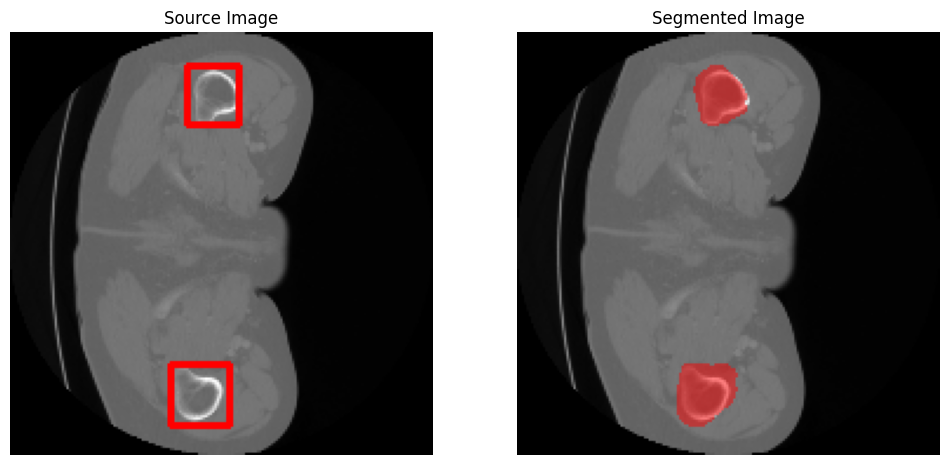

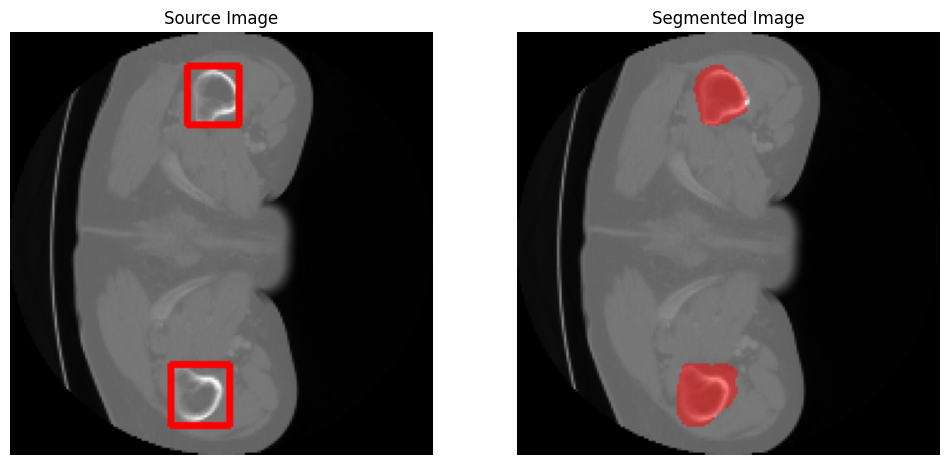

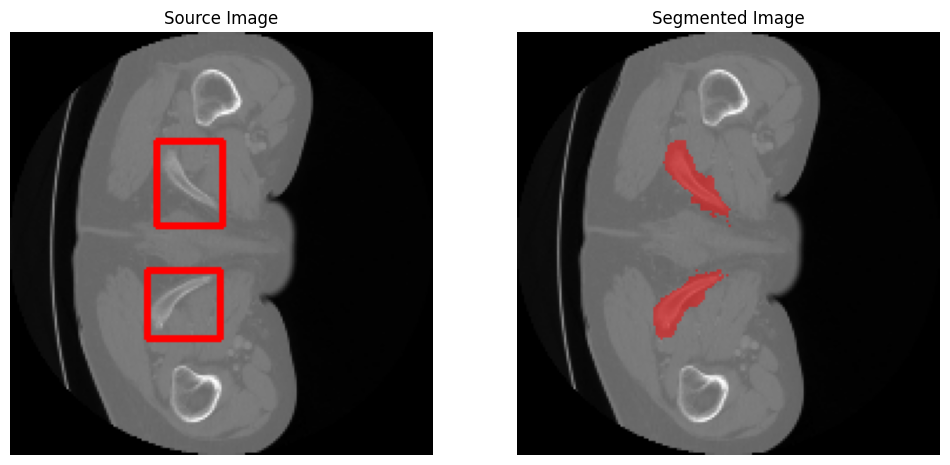

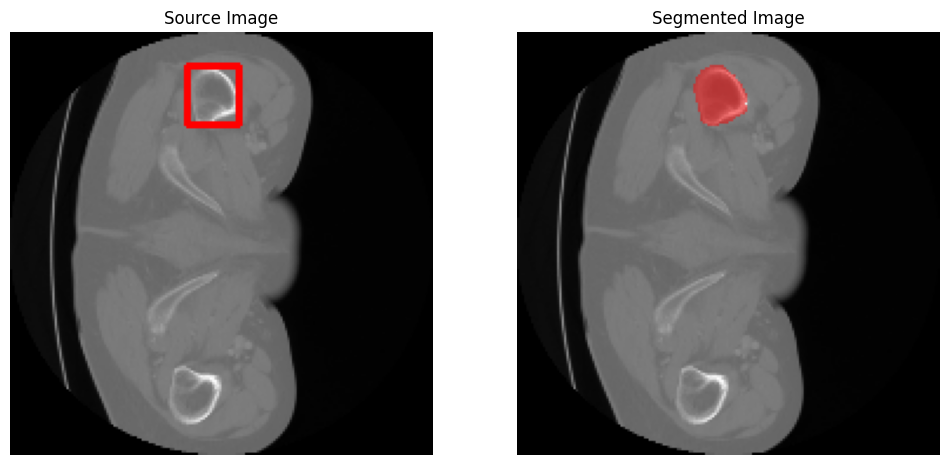

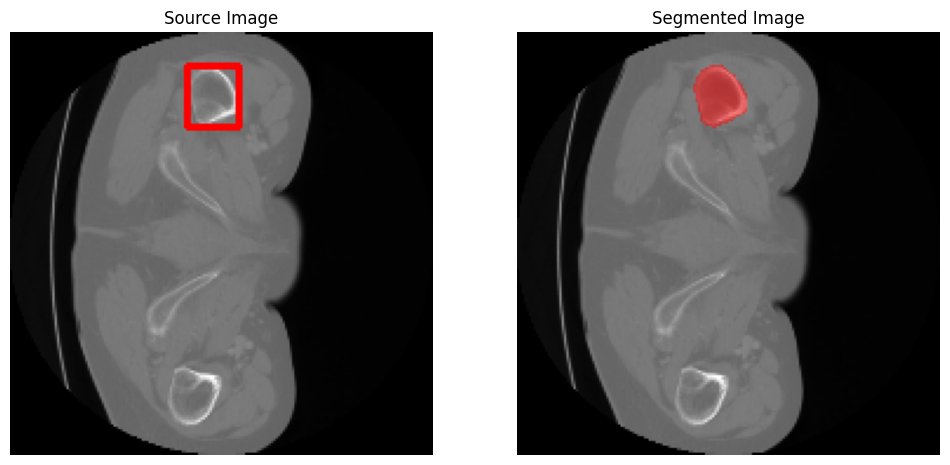

In [29]:
for i in range(len(masks)):
    slice_image = image_array[:, :, i]
    slice_rescaled = ((slice_image - np.min(slice_image)) / (np.max(slice_image) - np.min(slice_image)) * 255).astype(np.uint8)
    image_rgb = cv2.cvtColor(slice_rescaled, cv2.COLOR_GRAY2RGB)
    box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
    mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

    # Check if mask is valid for the current slice
    if masks[i] is not None and masks[i].any():
        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks[i]),
            mask=masks[i]
        )
        source_image = box_annotator.annotate(scene=image_rgb.copy(), detections=detections)
        segmented_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)
    else:
        print(f"Slice {i}: No valid mask available for segmentation.")
        source_image = image_rgb.copy()
        segmented_image = image_rgb.copy()

    sv.plot_images_grid(
        images=[source_image, segmented_image],
        grid_size=(1, 2),
        titles=['Source Image', 'Segmented Image']
    )


In [30]:
nifti_shape = (180, 180, len(masks))  # Final shape
nifti_volume = np.zeros(nifti_shape, dtype=np.uint8)
nifti_volume.shape

(180, 180, 5)

In [31]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

new_mask = []
for mask in masks:
    result = np.any(mask, axis=0)  # Find any non-zero pixel along the mask
    new_mask.append(result)

for i, mask in enumerate(new_mask):
    nifti_volume[:, :, i] = mask  # Directly assign 2D mask to the NIfTI volume

# Save the new NIfTI image
nifti_img = nib.Nifti1Image(nifti_volume, affine=np.eye(4))
nib.save(nifti_img, 'segmented_images.nii.gz')

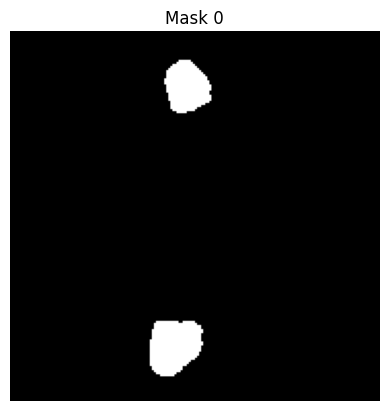

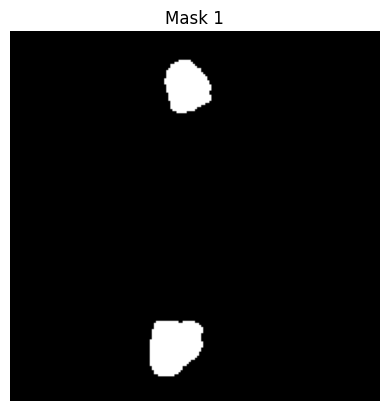

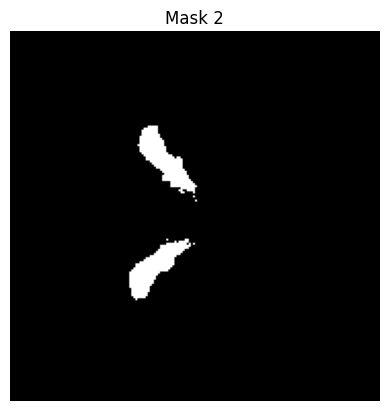

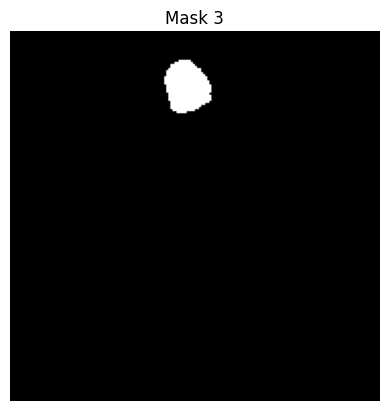

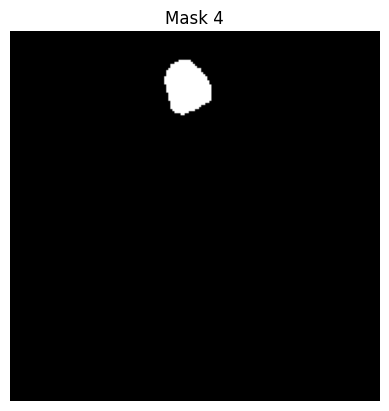

In [32]:
# Load and display the NIfTI image
nifti = nib.load('segmented_images.nii.gz')
image_array = nifti.get_fdata()
image_len = image_array.shape[2]  # Number of slices along the third dimension

# Plot each mask
for i in range(image_len):
    plt.imshow(image_array[:, :, i], cmap="gray")
    plt.axis("off")
    plt.title(f"Mask {i}")
    plt.show()